In [1]:
import numpy as np
import keras.backend as K
from keras.regularizers import l2
import keras
from keras.models import Model, load_model
from keras.layers import Input, LSTM, Dense, GRU, Embedding, Bidirectional, Flatten, Dropout, Lambda
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
from keras.utils import to_categorical
from keras.callbacks import History ,ModelCheckpoint, EarlyStopping
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import add, dot, concatenate, multiply
import numpy as np
from keras.layers import Dot
from keras.initializers import Zeros
import random
import pandas as pd
from sklearn.preprocessing import scale,MinMaxScaler
from sklearn.utils import shuffle
from keras.utils import get_custom_objects
import matplotlib.pyplot as plt
% matplotlib inline
%env CUDA_VISIBLE_DEVICES=2
import pickle
import seaborn as sns
sns.set(style='darkgrid', rc={'figure.facecolor':'white'}, font_scale=1.2)

Using TensorFlow backend.


env: CUDA_VISIBLE_DEVICES=2


In [2]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

print("train data shape",train_data.shape)
print("test data shape", test_data.shape)

all_UMpair = pd.concat([train_data,test_data])[["UserID","MovieID"]]

# create dictionary to encode UserID and MovieID
user2id = {}
movie2id = {}
for i, UserID in enumerate(np.unique(np.concatenate((train_data["UserID"],test_data["UserID"])))):
    user2id[UserID] = i
for j, MovieID in enumerate(np.unique(np.concatenate((train_data["MovieID"],test_data["MovieID"])))):
    movie2id[MovieID] = j
num_user = len(user2id)
num_movie = len(movie2id)
print("number of user",num_user)
print("number of movie",num_movie)

train data shape (899873, 4)
test data shape (100336, 3)
number of user 6040
number of movie 3706


In [3]:
train_user = np.array([ user2id[i] for i in train_data["UserID"]])
train_movie = np.array([ movie2id[j] for j in train_data["MovieID"]])
train_rating = np.array(train_data["Rating"])

total_sample_size =  len(train_rating)
print("total train sample",total_sample_size)

total train sample 899873


In [4]:
def MF_model(n_users, n_items, latent_dim=128,bias=True,normalize=False):
    if normalize:
        def rmse(y_true, y_pred):
            y_true = y_true*1.116897661+3.58171208
            y_pred = y_pred*1.116897661+3.58171208
            y_pred = K.clip(y_pred, 1.0, 5.0)
            return K.sqrt(K.mean(K.pow(y_true - y_pred, 2)))
    else:
        def rmse(y_true, y_pred):
            y_pred = K.clip(y_pred, 1.0, 5.0)
            return K.sqrt(K.mean(K.pow(y_true - y_pred, 2)))
    get_custom_objects().update({"rmse": rmse})
    user_input = Input(shape=[1])
    item_input = Input(shape=[1])
    user_vec = Embedding(n_users, latent_dim, embeddings_initializer="random_normal")(user_input)
    user_vec = Flatten()(user_vec)
    item_vec = Embedding(n_items, latent_dim, embeddings_initializer="random_normal")(item_input)
    item_vec = Flatten()(item_vec)
    #bias
    
    
    r_hat = dot([user_vec,item_vec],axes=1)
    if bias:
        print("Bias")
        user_bias = Embedding(n_users,1, embeddings_initializer="zeros")(user_input)
        user_bias = Flatten()(user_bias)
        item_bias = Embedding(n_items, 1, embeddings_initializer="zeros")(item_input)
        item_bias = Flatten()(item_bias)
        r_hat = add([r_hat, user_bias, item_bias])
    model = Model([user_input,item_input],r_hat)
    model.compile(loss="mse", optimizer="adam", metrics=[rmse])
    return model

In [5]:
batch_size = 256
epochs = 10
MF = MF_model(num_user,num_movie,latent_dim=20,bias=False)
train_user_, train_movie_, train_rating_ = shuffle(train_user, train_movie, train_rating)
hist = History()
early_stop = EarlyStopping(monitor="val_rmse", patience=3)
MF.fit([train_user_, train_movie_], train_rating_,
              batch_size=batch_size,
              epochs=epochs,
              validation_split=0.1,callbacks=[ hist])

Train on 809885 samples, validate on 89988 samples
Epoch 1/10
809885/809885 [==============================] - 12s - loss: 6.5123 - rmse: 1.9852 - val_loss: 1.1634 - val_rmse: 1.0725
Epoch 2/10
809885/809885 [==============================] - 11s - loss: 0.9381 - rmse: 0.9645 - val_loss: 0.8712 - val_rmse: 0.9308
Epoch 3/10
809885/809885 [==============================] - 11s - loss: 0.8322 - rmse: 0.9101 - val_loss: 0.8358 - val_rmse: 0.9121
Epoch 4/10
809885/809885 [==============================] - 10s - loss: 0.8027 - rmse: 0.8941 - val_loss: 0.8183 - val_rmse: 0.9027
Epoch 5/10
809885/809885 [==============================] - 10s - loss: 0.7799 - rmse: 0.8815 - val_loss: 0.8035 - val_rmse: 0.8946
Epoch 6/10
809885/809885 [==============================] - 11s - loss: 0.7599 - rmse: 0.8703 - val_loss: 0.7940 - val_rmse: 0.8895
Epoch 7/10
809885/809885 [==============================] - 11s - loss: 0.7405 - rmse: 0.8591 - val_loss: 0.7850 - val_rmse: 0.8843
Epoch 8/10
809885/809885 

In [6]:
batch_size = 1024
epochs = 30

MF = MF_model(num_user,num_movie,latent_dim=20,bias=False,normalize=True)
train_user_, train_movie_, train_rating_ = shuffle(train_user, train_movie, scale(train_rating))
hist_normal = History()
early_stop = EarlyStopping(monitor="val_rmse", patience=3)
MF.fit([train_user_, train_movie_], train_rating_,
              batch_size=batch_size,
              epochs=epochs,
              validation_split=0.05,callbacks=[hist_normal])

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


Train on 854879 samples, validate on 44994 samples
Epoch 1/30
854879/854879 [==============================] - 3s - loss: 0.9859 - rmse: 1.1087 - val_loss: 0.9137 - val_rmse: 1.0674
Epoch 2/30
854879/854879 [==============================] - 3s - loss: 0.7527 - rmse: 0.9678 - val_loss: 0.6797 - val_rmse: 0.9204
Epoch 3/30
854879/854879 [==============================] - 3s - loss: 0.6313 - rmse: 0.8870 - val_loss: 0.6383 - val_rmse: 0.8919
Epoch 4/30
854879/854879 [==============================] - 3s - loss: 0.5915 - rmse: 0.8586 - val_loss: 0.6201 - val_rmse: 0.8791
Epoch 5/30
854879/854879 [==============================] - 3s - loss: 0.5651 - rmse: 0.8392 - val_loss: 0.6110 - val_rmse: 0.8726
Epoch 6/30
854879/854879 [==============================] - 3s - loss: 0.5446 - rmse: 0.8238 - val_loss: 0.6063 - val_rmse: 0.8691
Epoch 7/30
854879/854879 [==============================] - 3s - loss: 0.5273 - rmse: 0.8104 - val_loss: 0.6038 - val_rmse: 0.8672
Epoch 8/30
854879/854879 [======

### P1: 請比較有無normalize(在rating上)的差別。並說明如何normalize. (1%)

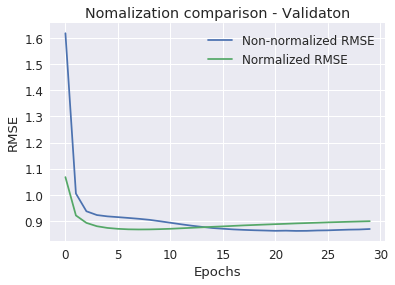

In [7]:
plt.plot(hist.history["val_rmse"],label="Non-normalized RMSE")
plt.plot(hist_normal.history["val_rmse"],label="Normalized RMSE")
plt.title("Nomalization comparison - Validaton")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend()
plt.show()

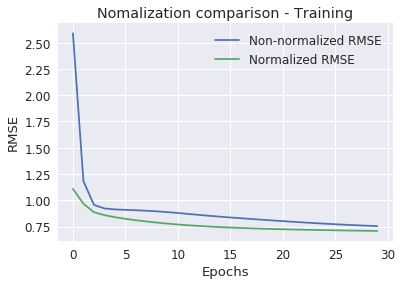

In [8]:
plt.plot(hist.history["rmse"],label="Non-normalized RMSE")
plt.plot(hist_normal.history["rmse"],label="Normalized RMSE")
plt.title("Nomalization comparison - Training")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend()
plt.show()

### P2: 比較不同的latent dimension的結果(1%)

In [9]:
train_rmse = []
valid_rmse = []
batch_size = 1024
epochs =30
for lant in [8,16,32,64,128,256]:
    MF = MF_model(num_user,num_movie,latent_dim=lant,bias=False)
    train_user_, train_movie_, train_rating_ = shuffle(train_user, train_movie, train_rating)
    hist_latent = History()
    early_stop = EarlyStopping(monitor="val_rmse", patience=3)
    MF.fit([train_user_, train_movie_], train_rating_,
                  batch_size=batch_size,
                  epochs=epochs,
                  validation_split=0.05,callbacks=[ hist_latent])
    train_rmse.append(hist_latent.history["rmse"])
    valid_rmse.append(hist_latent.history["val_rmse"])

Train on 854879 samples, validate on 44994 samples
Epoch 1/30
854879/854879 [==============================] - 3s - loss: 12.3536 - rmse: 2.7770 - val_loss: 6.2295 - val_rmse: 2.4012
Epoch 2/30
854879/854879 [==============================] - 3s - loss: 2.6919 - rmse: 1.5798 - val_loss: 1.4419 - val_rmse: 1.1929
Epoch 3/30
854879/854879 [==============================] - 3s - loss: 1.1602 - rmse: 1.0719 - val_loss: 1.0205 - val_rmse: 1.0067
Epoch 4/30
854879/854879 [==============================] - 3s - loss: 0.9360 - rmse: 0.9655 - val_loss: 0.9106 - val_rmse: 0.9520
Epoch 5/30
854879/854879 [==============================] - 3s - loss: 0.8699 - rmse: 0.9313 - val_loss: 0.8729 - val_rmse: 0.9324
Epoch 6/30
854879/854879 [==============================] - 3s - loss: 0.8459 - rmse: 0.9187 - val_loss: 0.8570 - val_rmse: 0.9241
Epoch 7/30
854879/854879 [==============================] - 3s - loss: 0.8359 - rmse: 0.9133 - val_loss: 0.8497 - val_rmse: 0.9203
Epoch 8/30
854879/854879 [=====

854879/854879 [==============================] - 2s - loss: 1.2526 - rmse: 1.1060 - val_loss: 0.9520 - val_rmse: 0.9732
Epoch 3/30
854879/854879 [==============================] - 3s - loss: 0.8732 - rmse: 0.9330 - val_loss: 0.8607 - val_rmse: 0.9260
Epoch 4/30
854879/854879 [==============================] - 3s - loss: 0.8168 - rmse: 0.9029 - val_loss: 0.8249 - val_rmse: 0.9068
Epoch 5/30
854879/854879 [==============================] - 3s - loss: 0.7835 - rmse: 0.8845 - val_loss: 0.8038 - val_rmse: 0.8952
Epoch 6/30
854879/854879 [==============================] - 3s - loss: 0.7596 - rmse: 0.8709 - val_loss: 0.7897 - val_rmse: 0.8873
Epoch 7/30
854879/854879 [==============================] - 3s - loss: 0.7410 - rmse: 0.8602 - val_loss: 0.7807 - val_rmse: 0.8822
Epoch 8/30
854879/854879 [==============================] - 3s - loss: 0.7251 - rmse: 0.8509 - val_loss: 0.7728 - val_rmse: 0.8777
Epoch 9/30
854879/854879 [==============================] - 3s - loss: 0.7094 - rmse: 0.8416 -

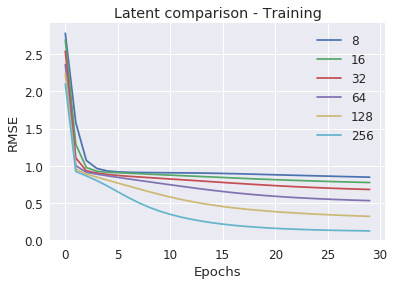

In [10]:
for i,j in enumerate([8,16,32,64,128,256]):
    plt.plot(train_rmse[i],label=str(j))
plt.title("Latent comparison - Training")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend()
plt.show()

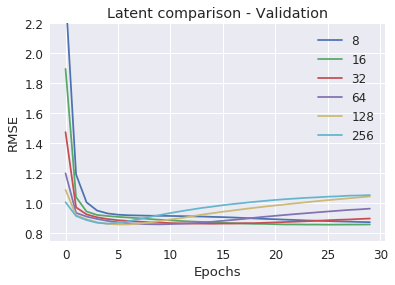

In [11]:
for i,j in enumerate([8,16,32,64,128,256]):
    plt.plot(valid_rmse[i],label=str(j))
plt.title("Latent comparison - Validation")
plt.ylim(0.75,2.2)
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend()
plt.show()

## P3: 比較有無bias的結果。(1%)

In [6]:
batch_size = 256
epochs = 10
MF = MF_model(num_user,num_movie,latent_dim=15,bias=True,normalize=False)
train_user_, train_movie_, train_rating_ = shuffle(train_user, train_movie, train_rating)
hist_bias = History()
early_stop = EarlyStopping(monitor="val_rmse", patience=3)
MF.fit([train_user_, train_movie_], train_rating_,
              batch_size=batch_size,
              epochs=epochs,
              validation_split=0.1,callbacks=[ hist_bias])

Bias
Train on 809885 samples, validate on 89988 samples
Epoch 1/10
809885/809885 [==============================] - 13s - loss: 5.7390 - rmse: 1.9663 - val_loss: 1.1246 - val_rmse: 1.0569
Epoch 2/10
809885/809885 [==============================] - 13s - loss: 0.9278 - rmse: 0.9605 - val_loss: 0.8638 - val_rmse: 0.9278
Epoch 3/10
809885/809885 [==============================] - 13s - loss: 0.8358 - rmse: 0.9126 - val_loss: 0.8335 - val_rmse: 0.9114
Epoch 4/10
809885/809885 [==============================] - 13s - loss: 0.8069 - rmse: 0.8969 - val_loss: 0.8099 - val_rmse: 0.8987
Epoch 5/10
809885/809885 [==============================] - 13s - loss: 0.7820 - rmse: 0.8830 - val_loss: 0.7957 - val_rmse: 0.8907
Epoch 6/10
809885/809885 [==============================] - 13s - loss: 0.7610 - rmse: 0.8710 - val_loss: 0.7828 - val_rmse: 0.8834
Epoch 7/10
809885/809885 [==============================] - 12s - loss: 0.7413 - rmse: 0.8597 - val_loss: 0.7728 - val_rmse: 0.8777
Epoch 8/10
809885/80

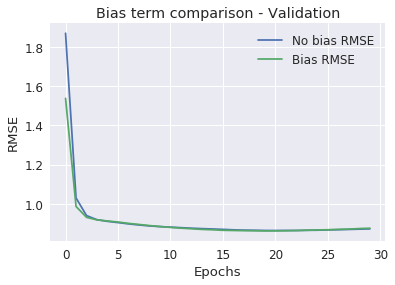

In [27]:
plt.plot(hist.history["val_rmse"],label="No bias RMSE")

plt.plot(hist_bias.history["val_rmse"],label="Bias RMSE")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.title("Bias term comparison - Validation")
plt.legend()
plt.show()

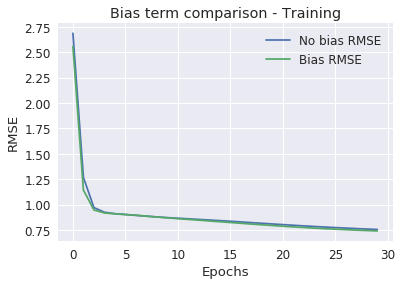

In [28]:
plt.plot(hist.history["rmse"],label="No bias RMSE")
plt.plot(hist_bias.history["rmse"],label="Bias RMSE")
plt.title("Bias term comparison - Training")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend()
plt.show()

## P4: 請試著用DNN(投影片p.28)來解決這個問題，並且說明實做的方法(方法不限)。並比較MF和NN的結果，討論結果的差異。(1%)

In [15]:
def NN_model(n_users, n_items, latent_dim=128,normalize=False):
    if normalize:
        def rmse(y_true, y_pred):
            y_true = y_true*1.116897661+3.58171208
            y_pred = y_pred*1.116897661+3.58171208
            y_pred = K.clip(y_pred, 1.0, 5.0)
            return K.sqrt(K.mean(K.pow(y_true - y_pred, 2)))
    else:
        def rmse(y_true, y_pred):
            y_pred = K.clip(y_pred, 1.0, 5.0)
            return K.sqrt(K.mean(K.pow(y_true - y_pred, 2)))
    get_custom_objects().update({"rmse": rmse})
    
    user_input = Input(shape=[1])
    item_input = Input(shape=[1])
    user_vec = Embedding(n_users, latent_dim, embeddings_initializer="random_normal")(user_input)
    user_vec = Flatten()(user_vec)
    item_vec = Embedding(n_items, latent_dim, embeddings_initializer="random_normal")(item_input)
    item_vec = Flatten()(item_vec)

    merge_vec = concatenate([item_vec,user_vec])
    
    hidden = Dense(128,activation="relu")(merge_vec)
    hidden = Dense(64,activation="relu")(hidden)
    output = Dense(1)(hidden)

    model = Model([user_input,item_input],output)
    model.compile(loss="mse", optimizer="adam", metrics=[rmse])
    return model

In [16]:
batch_size = 1024
epochs = 30

NN = NN_model(num_user,num_movie,latent_dim=20,normalize=False)
train_user_, train_movie_, train_rating_ = shuffle(train_user, train_movie, train_rating)
hist_NN = History()
early_stop = EarlyStopping(monitor="val_rmse", patience=3)
NN.fit([train_user_, train_movie_], train_rating_,
              batch_size=batch_size,
              epochs=epochs,
              validation_split=0.05,callbacks=[hist_NN])

Train on 854879 samples, validate on 44994 samples
Epoch 1/30
854879/854879 [==============================] - 5s - loss: 1.3674 - rmse: 1.0327 - val_loss: 0.8423 - val_rmse: 0.9173
Epoch 2/30
854879/854879 [==============================] - 4s - loss: 0.8229 - rmse: 0.9068 - val_loss: 0.8202 - val_rmse: 0.9053
Epoch 3/30
854879/854879 [==============================] - 4s - loss: 0.7967 - rmse: 0.8922 - val_loss: 0.8089 - val_rmse: 0.8989
Epoch 4/30
854879/854879 [==============================] - 4s - loss: 0.7766 - rmse: 0.8810 - val_loss: 0.7920 - val_rmse: 0.8896
Epoch 5/30
854879/854879 [==============================] - 4s - loss: 0.7567 - rmse: 0.8695 - val_loss: 0.7815 - val_rmse: 0.8836
Epoch 6/30
854879/854879 [==============================] - 4s - loss: 0.7399 - rmse: 0.8598 - val_loss: 0.7790 - val_rmse: 0.8823
Epoch 7/30
854879/854879 [==============================] - 4s - loss: 0.7250 - rmse: 0.8511 - val_loss: 0.7805 - val_rmse: 0.8829
Epoch 8/30
854879/854879 [======

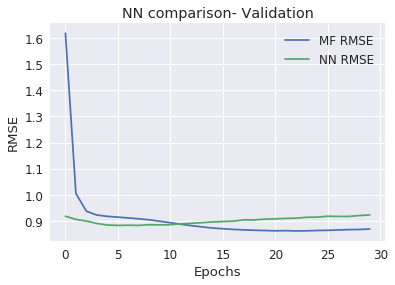

In [17]:
plt.plot(hist.history["val_rmse"],label="MF RMSE")

plt.plot(hist_NN.history["val_rmse"],label="NN RMSE")

plt.title("NN comparison- Validation")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend()
plt.show()

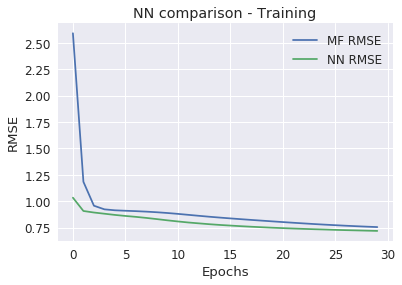

In [18]:
plt.plot(hist.history["rmse"],label="MF RMSE")
plt.plot(hist_NN.history["rmse"],label="NN RMSE")
plt.title("NN comparison - Training")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend()
plt.show()

In [19]:
test_user = np.array([user2id[i] for i in test_data["UserID"]])
test_movie = np.array([movie2id[i] for i in test_data["MovieID"]])
pred_rating = NN.predict([test_user,test_movie])
print(pred_rating)

[[ 4.29356718]
 [ 4.12751293]
 [ 4.39508724]
 ..., 
 [ 1.47380805]
 [ 3.7565589 ]
 [ 3.99380565]]


## P5: 請試著將movie的embedding用tsne降維後，將movie category當作label來作圖(如投影片p.29)。(1%)

In [20]:
movie_df = pd.read_csv("movies.csv",sep="::")
movie_df["Genres"] = movie_df["Genres"].apply(lambda x:x.split("|")[0])
print(movie_df.head())
user_emb = np.array(MF.layers[2].get_weights()).squeeze()
print("user embeddign shape:", user_emb.shape)
movie_emb = np.array(MF.layers[3].get_weights()).squeeze()
print("movie embedding shape:", movie_emb.shape)
np.save("user_emb.npy", user_emb)
np.save("movie_emb.npy",movie_emb)


   movieID                               Title     Genres
0        1                    Toy Story (1995)  Animation
1        2                      Jumanji (1995)  Adventure
2        3             Grumpier Old Men (1995)     Comedy
3        4            Waiting to Exhale (1995)     Comedy
4        5  Father of the Bride Part II (1995)     Comedy
user embeddign shape: (6040, 20)
movie embedding shape: (3706, 20)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [21]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0, perplexity=80)
vis_data = tsne.fit_transform(movie_emb)

In [22]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

inv_map = {v: k for k, v in movie2id.items()} 
y = []
for i in range(len(vis_data)):
    movie_id = inv_map[i]
    genres = movie_df.loc[movie_df["movieID"]==movie_id,"Genres"].tolist()
    y+=genres
y_c = le.fit_transform(y)

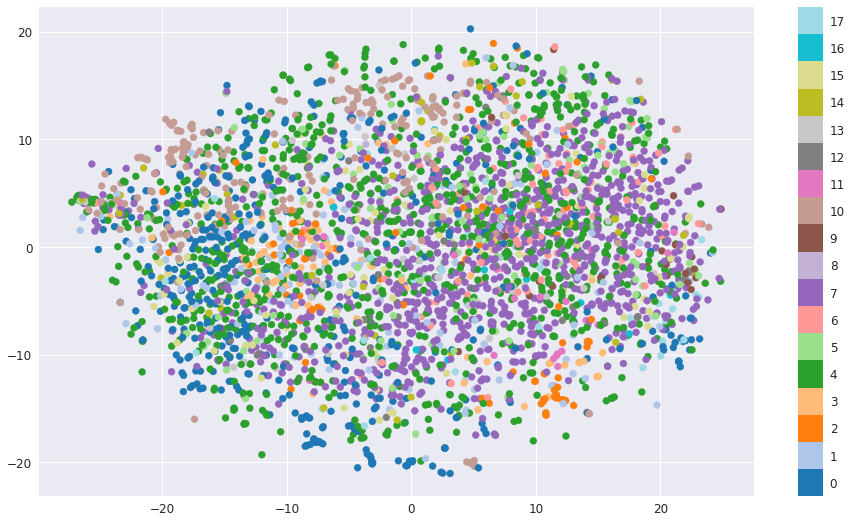

In [23]:
plt.figure(figsize=(16,9))
cm = plt.cm.get_cmap("tab20", 18)
sc = plt.scatter(vis_data[:,0], vis_data[:,1], c=y_c, cmap=cm)
plt.colorbar(ticks=range(18))
plt.clim(-0.5, 17.5)
plt.show()

In [120]:
pd.DataFrame({"class":list(range(18)),"genres":list(le.classes_)})

,class,genres
0,0,Action
1,1,Adventure
2,2,Animation
3,3,Children's
4,4,Comedy
5,5,Crime
6,6,Documentary
7,7,Drama
8,8,Fantasy
9,9,Film-Noir


In [117]:
len(le.classes_)

18

## BONUS: 試著使用除了rating以外的feature, 並說明你的作法和結果，結果好壞不會影響評分。(1%)

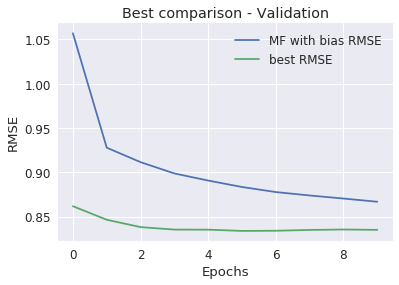

In [11]:
kaggle_val = [0.8617,0.8464,0.8381,0.8353,0.8352,0.8338,0.8340,0.8349,0.8354,0.8350]

plt.plot(hist_bias.history["val_rmse"],label="MF with bias RMSE")
plt.plot(kaggle_val,label="best RMSE")
plt.title("Best comparison - Validation")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend()
plt.show()